## Apply Azimi's relation to approximate attenuation

Bill Menke has a useful research note for this: https://www.ldeo.columbia.edu/~menke/www_users_menke/research_notes/menke_research_note166.pdf

In [2]:
import os
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import obspy
from obspy.clients.fdsn.client import Client 
import obspy
import pandas as pd
import scipy.ndimage
import geopy.distance
import random
client = Client('IRIS')
import scipy
import seaborn as sn

import matplotlib 
matplotlib.rcParams['font.family']=['Arial']
plt.rcParams.update({'font.size': 12})

#### Get input signal

In [3]:
# Get an input signal
file_name = 'results/HYSB1_HHN_3-10Hz_classifications.pickle'
with open(file_name,'rb') as handle:
    hysb1_classifications = pickle.load(handle)
hysb1_tremor = [c for c in hysb1_classifications if (c[2]>1) & (c[4]>100)]
tremor_t = hysb1_tremor[49][0]
t1 = tremor_t[0]-1500
t2 = tremor_t[1]+1000

In [4]:
st1 = client.get_waveforms("OO",'HYSB1', "*", "HHN",t1-5,t2+5,attach_response=True);
st1.filter('bandpass',freqmin=3,freqmax=10)
st1.remove_response()
st1.trim(starttime=t1,endtime=t2)

1 Trace(s) in Stream:
OO.HYSB1..HHN | 2018-06-26T12:36:05.540000Z - 2018-06-26T13:26:35.600000Z | 200.0 Hz, 606013 samples

#### Specify attenuation parameters
Distance (x), corner freq of Q, (f0), Q

In [5]:
x = 30 # km
c0 = 4.5 # S-wave velocity, km/s
f0 = 2 # Hz
Q = 200

#### Plot original signal

In [6]:
# Time series
Dt = 1/200
pulse0 = st1[0].data
N = len(pulse0)
t = [Dt * i for i in range(N)]

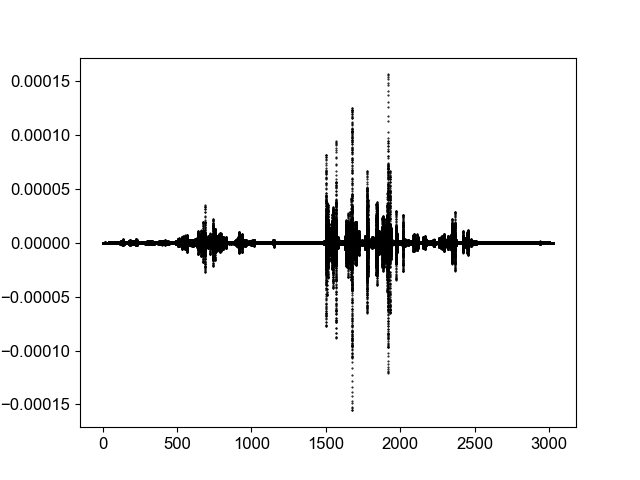

In [8]:
fig,ax = plt.subplots(1)
ax.plot(t,pulse0,'k.',markersize=1)
plt.show()

#### Set up for taking Fourier transform, convert to angular frequency, focus on non-negative frequency values only

In [9]:
# Standard fft setup
fny = 1 / (2*Dt)
N2 = int(N/2 + 1)
df = fny / (N/2)
f = [df * i for i in range(N2)]
w = [2 * np.pi * ff for ff in f]
w0 = 2 * np.pi * f0

#### Calculate attenuation function

In [10]:
a2 = 1 / (2*Q*c0)
a3 = 1 / w0
a = [ (a2 * ww) / ( 1 + (a3 * ww)) for ww in w ]
Qw = [w[i] / (2 * a[i] * c0) for i in range(len(a))[1:]]
Qw = [Q] + Qw
ds = [ -1 * ( 2 * a2 * np.log(a3 * ww)) / ( np.pi * (1 - (a3**2 * ww**2))) for ww in w]
ds[0] = 0
cw = [ 1 / ( (1/c0) +dds) for dds in ds]

/var/folders/k7/tk8jpcf12gdbjj0htp_vqbtc0000gn/T/ipykernel_55374/375419450.py:6: RuntimeWarning: divide by zero encountered in log
  ds = [ -1 * ( 2 * a2 * np.log(a3 * ww)) / ( np.pi * (1 - (a3**2 * ww**2))) for ww in w]


#### Fourier transform, cut out negative frequencies, apply attenuation function, and reform the negative frequency values by taking the complex conjugate of the positive frequency values

In [11]:
dt = np.fft.fft(pulse0)
dp = dt[:N2]
dp1 = [ dp[i] * np.exp(-1 * a[i] * x) * np.exp(1j * w[i] * ds[i] * x ) for i in range(len(dp))]
for i,d in enumerate(dp1):
    if np.isnan(d):
        dp1[i]=0
dtnew = dp1+list(np.conjugate(dp1[::-1]))
pulse = np.fft.ifft(dtnew)

/Users/zoekrauss/anaconda3/envs/alaska-ml/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


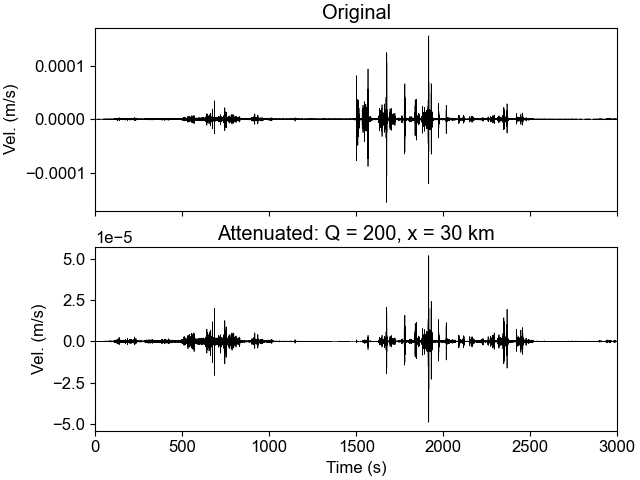

In [12]:
%matplotlib widget
fig,ax = plt.subplots(2,constrained_layout=True,sharex=True)
ax[0].plot(t,pulse0,'k-',linewidth=0.5)
ax[1].plot(t,pulse[:-1],'k-',linewidth=0.5)


ax[0].set_title('Original')
ax[1].set_title('Attenuated: Q = 200, x = 30 km')

ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Vel. (m/s)')
ax[1].set_ylabel('Vel. (m/s)')
ax[0].set_xlim([0,3000])

plt.show()

# plt.savefig('/Users/zoekrauss/ooi_tremor/tremor_figs/attenuation_50min.eps', bbox_inches='tight',dpi=400)